# PSPNet Model
In this notebook, we develop the Pyramid Scene Parsing network (based on https://github.com/Lextal/pspnet-pytorch), along with ResNet pretrainerd model.

In [1]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D
from util import *

In [2]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

In [3]:
# Credits
# Model implementation based on https://github.com/Lextal/pspnet-pytorch

# Data Augmentation
Here is some code for augmenting data. We are not using this yet, but we believe scaling, cropping, padding, changing color hues would be a great way to extend the data and improve model predictions.

In [4]:
import random
import numbers
import math
import collections

from PIL import ImageOps, Image
import numpy as np


class Padding:
    def __init__(self, pad):
        self.pad = pad

    def __call__(self, img):
        return ImageOps.expand(img, border=self.pad, fill=0)


class Scale:
    def __init__(self, size, interpolation=Image.NEAREST):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, imgmap):
        img, target = imgmap
        if isinstance(self.size, int):
            w, h = img.size
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return img, target
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
                return img.resize((ow, oh), self.interpolation), target.resize((ow, oh), self.interpolation)
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return img.resize((ow, oh), self.interpolation), target.resize((ow, oh), self.interpolation)
        else:
            return img.resize(self.size, self.interpolation), target.resize(self.size, self.interpolation)


class CenterCrop:
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, imgmap):
        img, target = imgmap
        w, h = img.size
        th, tw = self.size
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return img.crop((x1, y1, x1 + tw, y1 + th)), target.crop((x1, y1, x1 + tw, y1 + th))


class RandomCrop:
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, imgmap):
        img, target = imgmap
        w, h = img.size
        if self.size is not None:
            th, tw = self.size
            if w == tw and h == th:
                return img, target
            else:
                x1 = random.randint(0, w - tw)
                y1 = random.randint(0, h - th)
            return img.crop((x1, y1, x1 + tw, y1 + th)), target.crop((x1, y1, x1 + tw, y1 + th))
        else:
            return img, target


class RandomSizedCrop:

    def __init__(self, size, interpolation=Image.NEAREST):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, imgmap):
        img, target = imgmap
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(0.5, 1.0) * area
            aspect_ratio = random.uniform(3. / 4, 4. / 3)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                x1 = random.randint(0, img.size[0] - w)
                y1 = random.randint(0, img.size[1] - h)

                img = img.crop((x1, y1, x1 + w, y1 + h))
                target = target.crop((x1, y1, x1 + w, y1 + h))
                assert(img.size == (w, h))
                assert(target.size == (w, h))

                return img.resize((self.size, self.size), self.interpolation), \
                       target.resize((self.size, self.size), self.interpolation)

        # Fallback
        scale = Scale(self.size, interpolation=self.interpolation)
        crop = CenterCrop(self.size)
        return crop(scale((img, target)))


class RandomHorizontalFlip:

    def __call__(self, imgmap):
        img, target = imgmap
        if random.random() < 0.5:
            return img.transpose(Image.FLIP_LEFT_RIGHT), target.transpose(Image.FLIP_LEFT_RIGHT)
        return img, target


class RandomRotation:

    def __call__(self, imgmap, degree=10):
        img, target = imgmap
        deg = np.random.randint(-degree, degree, 1)[0]
        return img.rotate(deg), target.rotate(deg)

# Data Loader
We have already prepared our dataset. For local training and testing, we have split our training set to about 70/30, into training and validation. This allows us to validate our results locally and have a smaller dataset to train against.

Once we are certain, we will train our model on the full dataset for Kaggke submission.

In [5]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
level5data = LyftDataset(data_path='/home/ys3152/train_dataset', json_path='/home/ys3152/train_data', verbose=True)
class_heights = {'animal':0.51,'bicycle':1.44,'bus':3.44,'car':1.72,'emergency_vehicle':2.39,'motorcycle':1.59,
                'other_vehicle':3.23,'pedestrian':1.78,'truck':3.44}
# ARTIFACTS_FOLDER = "/home/hsb2140/deep-learnging-3d-object-dectation/input/lyft3d-mask-test-data/"
ARTIFACTS_FOLDER = "/home/hsb2140/artifacts/"
data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
#level5data = LyftDataset(data_path='/home/ys3152/test_dataset', json_path='/home/ys3152/test_data', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 10.5 seconds.
Reverse indexing ...
Done reverse indexing in 4.1 seconds.


In [6]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [7]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

print(len(train_df), len(validation_df), "train/validation split scene counts")

140 40 train/validation split scene counts


In [8]:
# sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
all_sample_tokens,scene_len = [],[]
for sample_token in tqdm_notebook(train_df.first_sample_token.values):
    i = 0
    while sample_token:
        all_sample_tokens.append(sample_token)
        sample = level5data.get("sample", sample_token)
        sample_token = sample["next"]
        i += 1
    scene_len.append(i)
#     print(len(all_sample_tokens[-1]))
    
print('Total number of tokens=',len(all_sample_tokens))


Total number of tokens= 17640


In [9]:
print()

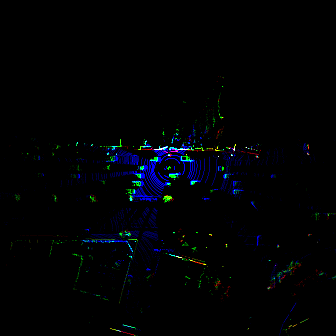

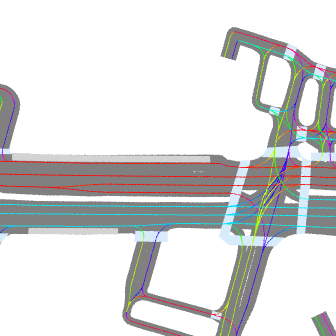

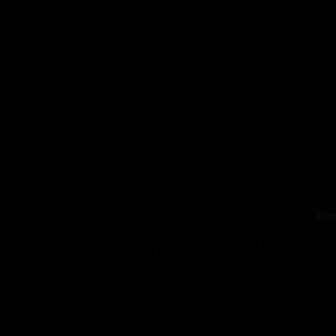

In [10]:
from IPython.display import Image, display

# Visualize
folder = "/home/hsb2140/deep-learnging-3d-object-dectation/input/lyft3d-mask-test-data/bev_train_data"
input_filepath = sorted(glob.glob(os.path.join(folder, "*_input.png")))[0]
map_fp = sorted(glob.glob(os.path.join(folder, "*map.png")))[0]
target_fp = sorted(glob.glob(os.path.join(folder, "*_target.png")))[0]

listOfImageNames = [input_filepath, map_fp, target_fp]

for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

# class BEVImageDataset(torch.utils.data.Dataset):
#     def __init__(self, sample_tokens, data_folder, is_train=True, ignore_map=True):
#         self.is_train = is_train
#         self.sample_tokens = sample_tokens
#         self.data_folder = data_folder
#         self.ignore_map = ignore_map
#     def __len__(self):
#         return len(self.sample_tokens)
#     def __getitem__(self, idx):
        
#         sample_token = self.sample_tokens[idx]
#         # Get file path, assuming data already preprocessed and stored in data_folder
#         input_filepath = os.path.join(self.data_folder,f"{sample_token}_input.png")
        
#         target = None
# #         if self.is_train:
#         target_filepath = os.path.join(self.data_folder,f"{sample_token}_target.png")
#         target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
#         if target is None:
#             print()
#         target = target.astype(np.int64)
#         target = torch.from_numpy(target)
        
#         im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
# #         if not self.ignore_map:
# #             map_filepath = os.path.join(self.data_folder,f"{sample_token}_map.png")
# #             map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
# #             # Concatenate image and map for network input
# #             im = np.concatenate((im, map_im), axis=2)
#         im = im.astype(np.float32)/255
#         im = torch.from_numpy(im.transpose(2,0,1))
        
#         if target is None:
#             print(sample_token, target_filepath)
        
# #         if not self.is_train:
# #             return im, sample_token
# #         else:
#         return im, target, sample_token

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token

data_folder = '/home/hsb2140/artifacts/bev_train_data/'
input_filepaths = sorted(glob.glob(os.path.join(data_folder, "*_input.png")))
# map_filepaths = sorted(glob.glob(os.path.join(data_folder, "*_map.png")))
target_filepaths = sorted(glob.glob(os.path.join(data_folder, "*_target.png")))

# train_data_folder = '/home/hsb2140/deep-learnging-3d-object-dectation/input/lyft3d-mask-test-data/bev_train_data'

# Use for Local training (train/validation) split 50/50 - data already split 50/50 and stored
# test_data_folder = '/home/hsb2140/deep-learnging-3d-object-dectation/input/lyft3d-mask-test-data/test_data/test_data'
data_folder = '/home/hsb2140/deep-learnging-3d-object-dectation/input/lyft3d-mask-test-data/bev_train_data'
print(data_folder)
print(len(all_sample_tokens))
batch_size=16
# train_dataset = BEVImageDataset(all_sample_tokens, data_folder, is_train=True, ignore_map=True)
train_dataset = BEVImageDataset(input_filepaths, target_filepaths)
# train_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

/home/hsb2140/deep-learnging-3d-object-dectation/input/lyft3d-mask-test-data/bev_train_data
17640


# Model

In [12]:
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import model_zoo
from torchvision.models.densenet import densenet121, densenet161
from torchvision.models.squeezenet import squeezenet1_1


def load_weights_sequential(target, source_state):
    model_to_load= {k: v for k, v in source_state.items() if k in target.state_dict().keys()}
    target.load_state_dict(model_to_load)

'''
    Implementation of dilated ResNet-101 with deep supervision. Downsampling is changed to 8x
'''
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, dilation=dilation, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride=stride, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, stride=1, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, dilation=dilation,
                               padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers=(3, 4, 23, 3)):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x_3 = self.layer3(x)
        x = self.layer4(x_3)

        return x, x_3


'''
    Implementation of DenseNet with deep supervision. Downsampling is changed to 8x 
'''


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                            growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                            kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features, downsample=True):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        if downsample:
            self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))
        else:
            self.add_module('pool', nn.AvgPool2d(kernel_size=1, stride=1))  # compatibility hack


class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, pretrained=True):

        super(DenseNet, self).__init__()

        # First convolution
        self.start_features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features

        init_weights = list(densenet121(pretrained=True).features.children())
        start = 0
        for i, c in enumerate(self.start_features.children()):
            if pretrained:
                c.load_state_dict(init_weights[i].state_dict())
            start += 1
        self.blocks = nn.ModuleList()
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            if pretrained:
                block.load_state_dict(init_weights[start].state_dict())
            start += 1
            self.blocks.append(block)
            setattr(self, 'denseblock%d' % (i + 1), block)

            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                downsample = i < 1
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2,
                                    downsample=downsample)
                if pretrained:
                    trans.load_state_dict(init_weights[start].state_dict())
                start += 1
                self.blocks.append(trans)
                setattr(self, 'transition%d' % (i + 1), trans)
                num_features = num_features // 2

    def forward(self, x):
        out = self.start_features(x)
        deep_features = None
        for i, block in enumerate(self.blocks):
            out = block(out)
            if i == 5:
                deep_features = out

        return out, deep_features


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes, dilation=1):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=dilation, dilation=dilation)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, pretrained=False):
        super(SqueezeNet, self).__init__()

        self.feat_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.feat_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64)
        )
        self.feat_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Fire(128, 32, 128, 128, 2),
            Fire(256, 32, 128, 128, 2)
        )
        self.feat_4 = nn.Sequential(
            Fire(256, 48, 192, 192, 4),
            Fire(384, 48, 192, 192, 4),
            Fire(384, 64, 256, 256, 4),
            Fire(512, 64, 256, 256, 4)
        )
        if pretrained:
            weights = squeezenet1_1(pretrained=True).features.state_dict()
            load_weights_sequential(self, weights)

    def forward(self, x):
        f1 = self.feat_1(x)
        f2 = self.feat_2(f1)
        f3 = self.feat_3(f2)
        f4 = self.feat_4(f3)
        return f4, f3


'''
    Handy methods for construction
'''


def squeezenet(pretrained=True):
    return SqueezeNet(pretrained)


def densenet(pretrained=True):
    return DenseNet(pretrained=pretrained)


def resnet18(pretrained=True):
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=True):
    model = ResNet(BasicBlock, [3, 4, 6, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=True):
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=True):
    model = ResNet(Bottleneck, [3, 4, 23, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=True):
    model = ResNet(Bottleneck, [3, 8, 36, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet152']))
    return model

extractors = {}
extractors['squeezenet'] = squeezenet
extractors['densenet'] = densenet
extractors['resnet18'] = resnet18
extractors['resnet34'] = resnet34
extractors['resnet50'] = resnet50
extractors['resnet101'] = resnet101
extractors['resnet152'] = resnet152

In [13]:
import torch
from torch import nn
from torch.nn import functional as F

class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


class PSPUpsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x):
        h, w = 2 * x.size(2), 2 * x.size(3)
        p = F.upsample(input=x, size=(h, w), mode='bilinear')
        return self.conv(p)


class PSPNet(nn.Module):
    def __init__(self, n_classes=18, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet34',
                 pretrained=False):
        super().__init__()
#         self.feats = getattr(extractors, backend)(pretrained)
        self.feats = extractors[backend](pretrained)
        self.psp = PSPModule(psp_size, 1024, sizes)
        self.drop_1 = nn.Dropout2d(p=0.3)

        self.up_1 = PSPUpsample(1024, 256)
        self.up_2 = PSPUpsample(256, 64)
        self.up_3 = PSPUpsample(64, 64)

        self.drop_2 = nn.Dropout2d(p=0.15)
        self.final = nn.Sequential(
            nn.Conv2d(64, n_classes, kernel_size=1),
            nn.LogSoftmax()
        )

        self.classifier = nn.Sequential(
            nn.Linear(deep_features_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        f, class_f = self.feats(x) 
        p = self.psp(f)
        p = self.drop_1(p)

        p = self.up_1(p)
        p = self.drop_2(p)

        p = self.up_2(p)
        p = self.drop_2(p)

        p = self.up_3(p)
        p = self.drop_2(p)

        auxiliary = F.adaptive_max_pool2d(input=class_f, output_size=(1, 1)).view(-1, class_f.size(1))

        return self.final(p), self.classifier(auxiliary)

# Training

In [14]:
import torch

# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)
print(device)

cuda


In [15]:
import os

from torch import nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm import tqdm
import numpy as np
from radamoptimizer import *

models = {
    'squeezenet': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='squeezenet'),
    'densenet': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=1024, deep_features_size=512, backend='densenet'),
    'resnet18': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='resnet18'),
    'resnet34': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='resnet34'),
    'resnet50': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet50'),
    'resnet101': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet101'),
    'resnet152': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet152')
}

def build_network(snapshot, backend):
    epoch = 0
    backend = backend.lower()
    net = models[backend]()
    net = nn.DataParallel(net)
    if snapshot is not None:
        _, epoch = os.path.basename(snapshot).split('_')
        epoch = int(epoch)
        net.load_state_dict(torch.load(snapshot))
        logging.info("Snapshot for epoch {} loaded from {}".format(epoch, snapshot))
    net = net.cuda()
    return net, epoch


backend='resnet18'
snapshot=None
crop_x=256 
crop_y=256
batch_size=16
alpha=0.01
epochs=20
milestones='10,20,30'
gpu='0'

net, starting_epoch = build_network(snapshot, backend)

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*2)

'''
    To follow this training routine you need a DataLoader that yields the tuples of the following format:
    (Bx3xHxW FloatTensor x, BxHxW LongTensor y, BxN LongTensor y_cls) where
    x - batch of input images,
    y - batch of groung truth seg maps,
    y_cls - batch of 1D tensors of dimensionality N: N total number of classes, 
    y_cls[i, T] = 1 if class T is present in image i, 0 otherwise
'''
train_loader, class_weights, n_images = None, None, None

all_losses = []
optim = RAdam(net.parameters(), lr=1e-3)
        

# Train
TODO: Model fails with current data preprocessing because data has not been preprocessed to match the input of the network. **This is a work in progress.**

In [16]:
for epoch in range(epochs):
    print("Epoch", epoch)
    
    progress_bar = tqdm_notebook(dataloader)

    seg_criterion = nn.NLLLoss2d(weight=class_weights)
#     cls_criterion = nn.BCEWithLogitsLoss(weight=class_weights)
    epoch_losses = []
    net.train()
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        optim.zero_grad()
        
        X = X.to(device)  # [N, 3, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction, out_cls = net(X)  # [N, 2, H, W]
        
        seg_loss = seg_criterion(prediction, target) 
        #cls_loss = cls_criterion(out_cls, y_cls)
        loss = seg_loss + alpha
#         loss = seg_loss + alpha * cls_loss
#         loss = F.cross_entropy(prediction, target, weight=class_weights)
    
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

    print("Loss:", np.mean(epoch_losses))
    all_losses.extend(epoch_losses)

    checkpoint_filepath = os.path.join('/home/hsb2140/', "seg_restnet18pspnet_checkpoint_epoch_{}.pth".format(epoch))
    state = {'epoch': epoch + 1, 
             'model_state_dict': net.state_dict(),
             'optimizer_state_dict': optim.state_dict(), 
             'loss': seg_criterion }
    torch.save(state, checkpoint_filepath)
#     train_loss = np.mean(epoch_losses)


Epoch 0


/home/hsb2140/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:210: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "
/home/hsb2140/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hsb2140/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/hsb2140/miniconda3/lib/python3.7/site-pac


Loss: 0.40185818
Epoch 1



Loss: 0.034332786
Epoch 2



Loss: 0.025715081
Epoch 3



Loss: 0.022366265
Epoch 4



Loss: 0.020544393
Epoch 5



Loss: 0.019371957
Epoch 6



Loss: 0.018440153
Epoch 7



Loss: 0.01775145
Epoch 8



Loss: 0.017030312
Epoch 9



Loss: 0.01658215
Epoch 10



Loss: 0.016091995
Epoch 11



Loss: 0.015600695
Epoch 12



Loss: 0.015272542
Epoch 13



Loss: 0.0148688285
Epoch 14



Loss: 0.014674068
Epoch 15


KeyboardInterrupt: 

In [1]:
'''
Loss: 0.40185818
Epoch 1

Loss: 0.034332786
Epoch 2

Loss: 0.025715081
Epoch 3

Loss: 0.022366265
Epoch 4

Loss: 0.020544393
Epoch 5

Loss: 0.019371957
Epoch 6

Loss: 0.018440153
Epoch 7

Loss: 0.01775145
Epoch 8

Loss: 0.017030312
Epoch 9

Loss: 0.01658215
Epoch 10

Loss: 0.016091995
Epoch 11

Loss: 0.015600695
Epoch 12

Loss: 0.015272542
Epoch 13

Loss: 0.0148688285
Epoch 14

Loss: 0.014674068
Epoch 15
'''
import matplotlib.pyplot as plt
plt.plot(all_losses)

NameError: name 'all_losses' is not defined

In [ ]:
losses = [0.24649781,0.019393962,0.013151167,0.010835841, 0.009487289]
import matplotlib.pyplot as plt
plt.plot(losses)

# UNet

In [ ]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


def get_unet_model(in_channels=6, num_output_classes=2):
    model = UNet(in_channels=in_channels, n_classes=num_output_classes, wf=5, depth=4, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    model = nn.DataParallel(model)
    return model

In [ ]:
model10 = get_unet_model(num_output_classes=len(classes)+1)

state = torch.load('/home/hsb2140/deep-learnging-3d-object-dectation//input/lyft3d-mask-test-data/unet_checkpoint_epoch_10.pth')
model10.load_state_dict(state)
model10 = model10.to(device)
model10.eval();


# model9 = get_unet_model(num_output_classes=len(classes)+1)

# state = torch.load('/home/hsb2140/deep-learnging-3d-object-dectation//input/lyft3d-mask-test-data/unet_checkpoint_epoch_9.pth')
# model9.load_state_dict(state)
# model9 = model9.to(device)
# model9.eval();

# Test

In [ ]:
class Model:
    def __init__(self, models):
        self.models = models
    
    def __call__(self, x_psp, x_unet):
        res = []
        x_unet = x_unet.cuda()
        x_psp = x_psp.cuda()
        with torch.no_grad():
            psp_pred, _cls = self.models[0](x_psp)
            unet_pred = self.models[1](x_unet)
            res.append(psp_pred)
            res.append(unet_pred)
#             for m, t in self.models:
#                 if t == 'PSP':
#                     prediction, cls = m(x)
#                 else:
#                     prediction = m(x)
#                 res.append(prediction)
        res = torch.stack(res)
        return torch.mean(res, dim=0)
    
net7, _ = build_network(None, backend)
state = torch.load('/home/hsb2140/2_pspnet_checkpoint_epoch_7.pth')
net7.load_state_dict(state)
net7 = net7.to(device)
net7.eval();

# net6, _ = build_network(None, backend)
# state = torch.load('/home/hsb2140/2_pspnet_checkpoint_epoch_6.pth')
# net6.load_state_dict(state)
# net6 = net6.to(device)
# net6.eval();

In [ ]:
model = Model([net7,model10])

In [ ]:
class_heights = {'animal':0.51,'bicycle':1.44,'bus':3.44,'car':1.72,'emergency_vehicle':2.39,'motorcycle':1.59,
                'other_vehicle':3.23,'pedestrian':1.78,'truck':3.44}
level5data = LyftDataset(data_path='/home/ys3152/test_dataset', json_path='/home/ys3152/test_data', verbose=True)

In [ ]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

In [ ]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [ ]:
df.head()

In [ ]:
# sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
all_sample_tokens,scene_len = [],[]
for sample_token in tqdm_notebook(df.first_sample_token.values):
    i = 0
    while sample_token:
        all_sample_tokens.append(sample_token)
        sample = level5data.get("sample", sample_token)
        sample_token = sample["next"]
        i += 1
    scene_len.append(i)
#     print(len(all_sample_tokens[-1]))
    
print('Total number of tokens=',len(all_sample_tokens))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BEVImageTestDataset(torch.utils.data.Dataset):
    def __init__(self, sample_tokens, data_folder):
        self.sample_tokens = sample_tokens
        self.data_folder = data_folder
    def __len__(self):
        return len(self.sample_tokens)
    def __getitem__(self, idx):
        
        sample_token = self.sample_tokens[idx]
        input_filepath = os.path.join(self.data_folder,f"{sample_token}_input.png")
        map_filepath = os.path.join(self.data_folder,f"{sample_token}_map.png")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        m_im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
        m_im = np.concatenate((m_im, map_im), axis=2)
        
        im = im.astype(np.float32)/255
        m_im = m_im.astype(np.float32)/255
        im = torch.from_numpy(im.transpose(2,0,1))
        m_im = torch.from_numpy(m_im.transpose(2,0,1))
        
        return im, m_im, sample_token

test_data_folder = '/home/hsb2140/deep-learnging-3d-object-dectation/input/lyft3d-mask-test-data/test_data/test_data'

test_dataset = BEVImageTestDataset(all_sample_tokens,test_data_folder)

In [ ]:
# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)
print(np.array([1.0]*len(classes), dtype=np.float32))
print(class_weights)
print(device)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

net.eval();
import gc
gc.collect()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count()*2)
progress_bar = tqdm_notebook(test_loader)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
# predictions = np.zeros((len(test_loader), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

detection_boxes = []
detection_scores = []
detection_classes = []

# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 200

with torch.no_grad():
    for ii, (X, X2, batch_sample_tokens) in enumerate(progress_bar):

        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        prediction = model(X, X2)  # [N, 2, H, W]
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Get probabilities for non-background
        predictions_non_class0 = 255 - predictions[:,0]
        
        predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

        for i, p in enumerate(predictions_non_class0):
            thresholded_p = (p > background_threshold).astype(np.uint8)
            predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
    
            sample_boxes,sample_detection_scores,sample_detection_classes = calc_detection_box(predictions_opened[i],
                                                                                              predictions[i])
        
            detection_boxes.append(np.array(sample_boxes))
            detection_scores.append(sample_detection_scores)
            detection_classes.append(sample_detection_classes)
        
#         # Visualize the first prediction
#         if ii == 0:
#             visualize_predictions(X, prediction, apply_softmaxiii=False)
            

In [ ]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

# Create Camera of Predictions

In [ ]:
os.makedirs('/home/hsb2140/deep-learnging-3d-object-dectation/cam_viz',exist_ok=True)
 
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
import shutil

pred_box3ds = []

max_frames = 128
vid_count = 0
processed_samples = 0
for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    processed_samples += 1
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

#     box_height = 1.75
    box_height = np.array([class_heights[cls] for cls in sample_detection_class])

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height
    
    temp = []
    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box(
            token=sample_token,
            center=list(translation),
            size=list(size),
            orientation=Quaternion(quat),
            name=class_name,
            score=detection_score
        )
        
        temp.append(box3d)
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)


# Create Submission File

In [ ]:
sub = {}
for i in tqdm_notebook(range(len(pred_box3ds))):
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0]);
    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + \
    str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
    str(pred_box3ds[i].width) + ' ' \
    + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + str(yaw) + ' ' \
    + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('/home/ys3152/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
    sub[token] = ''

In [ ]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

In [ ]:
sub.tail()

In [ ]:
sub.to_csv('/home/hsb2140/lyft3d_pred_pspnet_unet_mean.csv',index=False)